In [60]:
library(tidyr)
library(dplyr)
library(ggplot2)

# Problema
Quando um classificador em produção apresenta uma piora na performance ou uma nova abordagem é proposta, o analista precisa comparar o classificador atual com o novo para escolher o melhor. Porém, o cenário de fluxos de dados apresenta desafios adicionais ao processamento em lote por não dispor de dados históricos ou esses não serem mais relevantes após mudanças de conceito.

## Dados estacionários balanceados

In [66]:
plot_metrics_evolution <- function (path) {
    data <- read.table(file=path, header=TRUE, sep=",")
    #print(head(no_drift_balanced))
    metrics <- data %>%
            rename(instance = classified.instances, recall_0 = Recall.for.class.0..percent., recall_1 = Recall.for.class.1..percent.) %>%
            filter(4 <= instance & instance <= 50000) %>%
            select(instance, recall_0, recall_1) %>%
            gather("metric", "value", recall_0, recall_1)
    #print(head(metrics))
    options(repr.plot.width=8, repr.plot.height=4)
    ggplot(data = metrics, mapping = aes(x = instance, y = value, color = metric)) +
        geom_line()
}

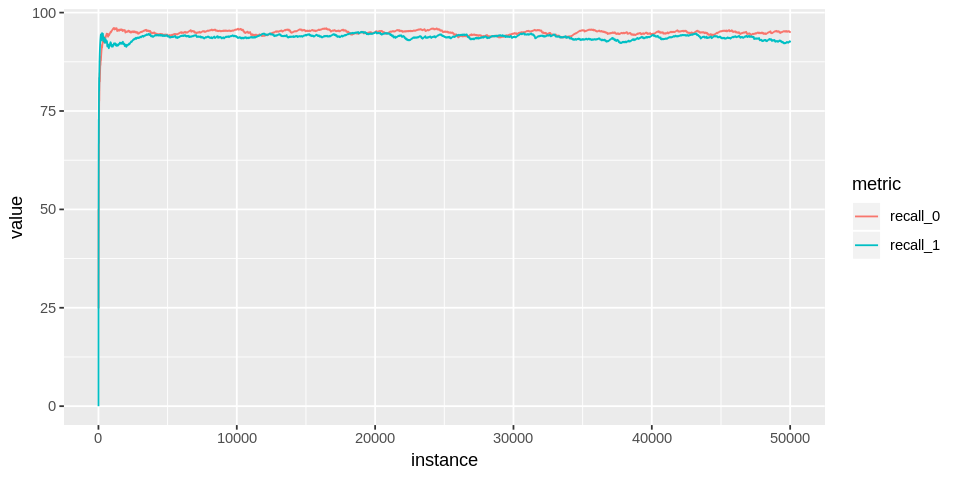

In [67]:
plot_metrics_evolution("../data/evaluation/naive_bayes/no_drift_balanced.csv")

$P(y|X) = P(X|y)P(y)$

## Mudança na verossimilhança

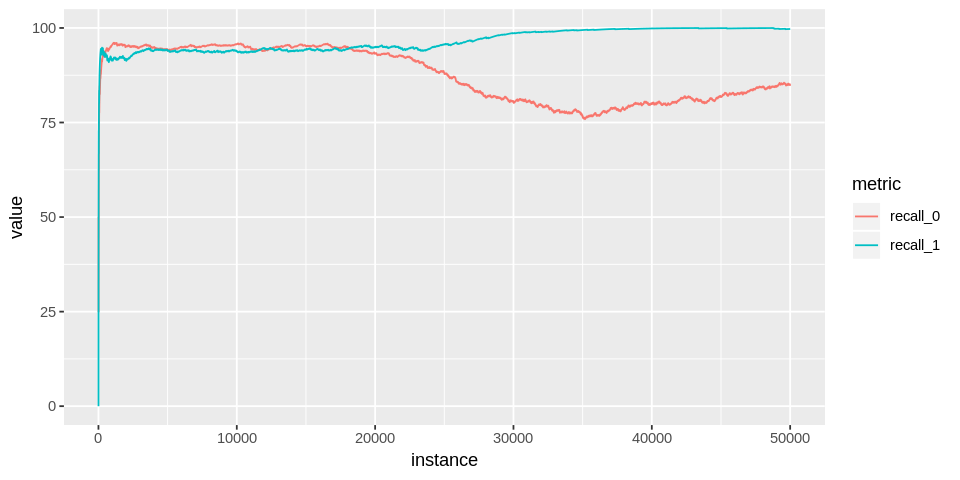

In [68]:
plot_metrics_evolution("../data/evaluation/naive_bayes/maximum_likelihood_drift.csv")

$P(y|X) = \underline{P(X|y)}P(y)$

## Mudança na probabilidade a priori (balanceamento)

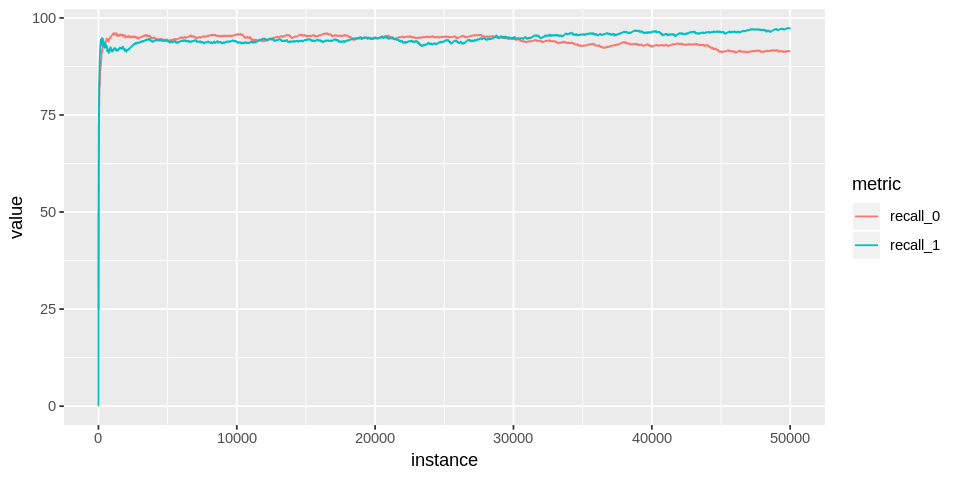

In [69]:
plot_metrics_evolution("../data/evaluation/naive_bayes/a_priori_drift.csv")

$P(y|X) = P(X|y)\underline{P(y)}$

# Objetivo
Comparar dois classificadores no cenário de fluxos de dados com a presença de mudança de conceito para auxiliar o analista a escolher qual deve ser mantido no ambiente de produção.

# Metodologia
## Descrição
* Testa e treina dois classificadores a cada novo exemplo no fluxo de dados.
 * Classificadores: Naive Bayes e OzaBagASHT.
* Calcular, **para cada classe**, uma tabela de contingência que conta os **acertos exclusivos** de cada classificador.
 * Métrica: um recall por classe, mas considerando apenas os acertos exclusivos.
 * Contagem na forma prequencial com fading factor 0,999.
* Aplicar dois testes de McNemar com base nas duas tabelas de contingência.
 * alfa: 0,05
* O classificador que vencer em mais testes é mantido em produção.

## Hipóteses
* Para cada classe:
 * $H_0: recall_1 = recall_2$
 * $H_1: recall_1 \neq recall_2$

# Resultados

## Comparação visual

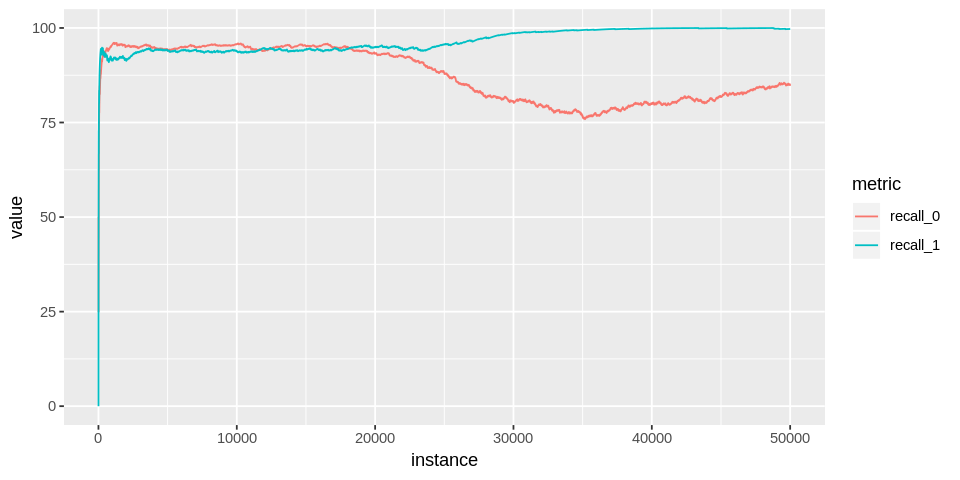

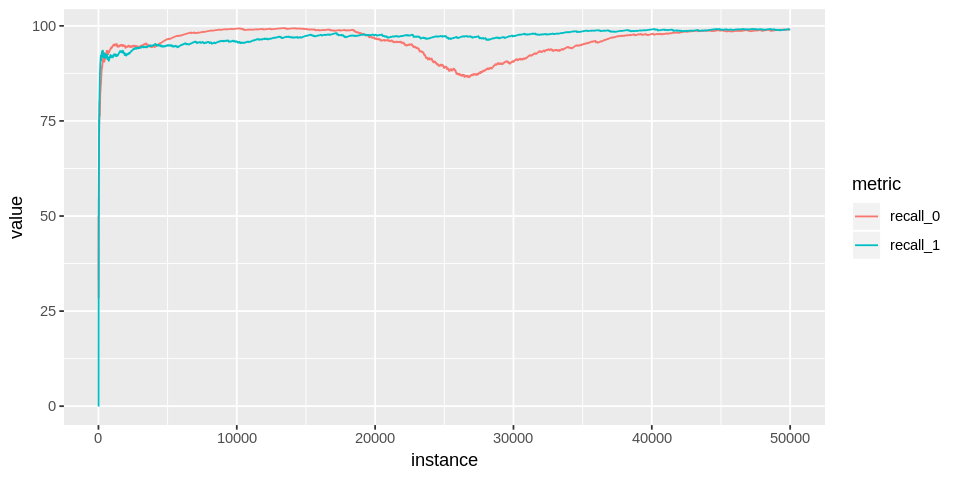

In [73]:
plot_metrics_evolution("../data/evaluation/naive_bayes/maximum_likelihood_drift.csv")
plot_metrics_evolution("../data/evaluation/oza_bag_asht/maximum_likelihood_drift.csv")

In [131]:
delta_2_hit <- function(current_metric, previous_metric) {
    return(sign(current_metric - previous_metric))
}
load_hit <- function(classifier) {
    path = sprintf("../data/evaluation/%s/no_drift_balanced.csv", classifier)
    data <- read.table(file=path, header=TRUE, sep=",")
    #print(head(data))
    metric <- data %>%
            rename(instance = classified.instances, recall_0 = Recall.for.class.0..percent., recall_1 = Recall.for.class.1..percent.) %>%
            filter(10 <= instance & instance <= 50000) %>%
            select(instance, recall_0, recall_1) %>%
            mutate(previous_instance = instance - 1)
    #print(head(metric))
    hit <- merge(metric, metric, by.x = "previous_instance", by.y = "instance") %>%
            transmute(instance = instance, hit_0 = delta_2_hit(recall_0.x, recall_0.y), hit_1 = delta_2_hit(recall_1.x, recall_1.y))
    return(hit)
}
classifier_1 <- load_hit("naive_bayes")
classifier_2 <- load_hit("oza_bag_asht")
hits <- merge(classifier_1, classifier_2, by = "instance") %>%
                    rename(hit_0.classifier_1 = hit_0.x, hit_1.classifier_1 = hit_1.x, hit_0.classifier_2 = hit_0.y, hit_1.classifier_2 = hit_1.y)
validation <- hits %>%
                filter(abs(hit_0.classifier_1) != abs(hit_0.classifier_2) | abs(hit_1.classifier_1) != abs(hit_1.classifier_2))
print(sprintf("This number must be zero: %s", nrow(validation)))
fading_factor = 0.999
contingency_table = matrix(c(0, 0, 0, 0),
       nrow = 2,
       dimnames = list("Classsifier 1" = c("Hit", "Miss"),
                       "Classifier 2" = c("Hit", "Miss")))
for (row in 1:nrow(hits)) {
#for (row in 1:100) {
    hit_0.classifier_1 <- hits[row, "hit_0.classifier_1"]
    hit_0.classifier_2 <- hits[row, "hit_0.classifier_2"]
    
    if (abs(hit_0.classifier_1) == 1 & abs(hit_0.classifier_2) == 1) {
        #print(contingency_table)
        contingency_table["Hit", "Hit"] = fading_factor * contingency_table["Hit", "Hit"]
        contingency_table["Hit", "Miss"] = fading_factor * contingency_table["Hit", "Miss"]
        contingency_table["Miss", "Hit"] = fading_factor * contingency_table["Miss", "Hit"]
        contingency_table["Miss", "Miss"] = fading_factor * contingency_table["Miss", "Miss"]
    }
    
    if (hit_0.classifier_1 == 1 & hit_0.classifier_2 == 1) {
        contingency_table["Hit", "Hit"] = 1
    } 
    if (hit_0.classifier_1 == 1 & hit_0.classifier_2 == -1) {
        contingency_table["Hit", "Miss"] = 1
        }
    if (hit_0.classifier_1 == -1 & hit_0.classifier_2 == 1) {
        contingency_table["Miss", "Hit"] = 1
    }
    if (hit_0.classifier_1 == -1 & hit_0.classifier_2 == -1) {
        contingency_table["Miss", "Miss"] = 1
    }
}                    
mcnemar.test(contingency_table)

[1] "This number must be zero: 0"



	McNemar's Chi-squared test with continuity correction

data:  contingency_table
McNemar's chi-squared = 0.28435, df = 1, p-value = 0.5939


# Conclusão